In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from espn_api.football import League, Team, Player

from copy import copy
from collections import Counter
from tabulate import tabulate as table

In [45]:
year = 2021

login = pd.read_csv('login.csv')
manager, league_name, league_id, swid, espn_s2 = login.iloc[1]

In [46]:
league = League(league_id=league_id,
                year=year,
                swid=swid, 
                espn_s2=espn_s2)

week = 4
league.load_roster_week(week)

team = league.teams[0]
# box_scores = league.box_scores(week)
# box_score = box_scores[0]

In [47]:
# Get a dictionary of the starting roster slots and number of each for the League (Week 1 must have passed already)
starting_roster_slots = Counter([p.slot_position for p in league.box_scores(1)[0].home_lineup if p.slot_position not in ['BE', 'IR']])

## Analytic functions

In [48]:
def get_lineup(league: League, team: Team, week: int, box_scores=None):
    ''' Return the lineup of the given team during the given week '''
    # Get the lineup for the team during the specified week
    if box_scores is None: box_scores = league.box_scores(week)
    for box_score in box_scores:
        if team == box_score.home_team:
            return box_score.home_lineup
        elif team == box_score.away_team:
            return box_score.away_lineup

def get_top_players(lineup: list, slot: str, n: int):
    ''' Takes a list of players and returns a list of the top n players based on points scored. '''
    # Gather players of the desired position
    eligible_players = []
    for player in lineup:
        if slot in player.eligibleSlots:
            eligible_players.append(player)
            
    return sorted(eligible_players, key=lambda x: x.points, reverse=True)[:n]


def get_best_lineup(lineup: list):
    ''' Returns the best possible lineup for team during the loaded week. '''
    # Save full roster
    saved_roster = copy(lineup)
    
    # Find Best Lineup
    best_lineup = []
    for slot in sorted(starting_roster_slots.keys(), key=len):  # Get best RB before best RB/WR/TE
        num_players = starting_roster_slots[slot]
        best_players = get_top_players(saved_roster, slot, num_players)
        best_lineup.extend(best_players)
        
        # Remove selected players from consideration for other slots
        for player in best_players:
            saved_roster.remove(player)

    return np.sum([player.points for player in best_lineup])


def get_best_trio(lineup: list):
    ''' Returns the the sum of the top QB/RB/Reciever trio for a team during the loaded week. '''
    qb = get_top_players(lineup, 'QB', 1)[0].points
    rb = get_top_players(lineup, 'RB', 1)[0].points
    wr = get_top_players(lineup, 'WR', 1)[0].points
    te = get_top_players(lineup, 'TE', 1)[0].points
    best_trio = round(qb + rb + max(wr, te), 2)
    return best_trio

def get_lineup_efficiency(lineup: list):
    max_score = get_best_lineup(lineup)
    real_score = np.sum([player.points for player in lineup if player.slot_position not in ('BE', 'IR')])
    return real_score / max_score
    
def get_weekly_finish(league: League, team: Team, week: int):
    ''' Returns the rank of a team compared to the rest of the league by points for (for the loaded week) '''
    league_scores = [tm.scores[week-1] for tm in league.teams]
    league_scores = sorted(league_scores, reverse=True)
    return league_scores.index(team.scores[week-1]) + 1

def get_num_out(lineup: list):
    ''' Returns the (esimated) number of players who did not play for a team for the loaded week (excluding IR slot players). '''
    num_out = 0
    # TODO: write new code based on if player was injured
    return num_out

def avg_slot_score(lineup: list, slot: str):
    ''' 
    Returns the average score for starting players of a specified slot.
    `lineup` is either BoxScore().away_lineup or BoxScore().home_lineup (a list of BoxPlayers)
    '''
    return np.mean([player.points for player in lineup if player.slot_position == slot])

def sum_bench_points(lineup: list):
    ''' 
    Returns the total score for bench players
    `lineup` is either BoxScore().away_lineup or BoxScore().home_lineup (a list of BoxPlayers)
    '''
    return np.sum([player.points for player in lineup if player.slot_position == 'BE'])

def print_weekly_stats(league: League, team: Team, week: int):
    ''' Print the weekly stats for the team during a given week. '''

    lineup = get_lineup(league, team, week)
    stats_table = [['Week Score: ', team.scores[week-1]],
                   ['Best Possible Lineup: ', get_best_lineup(lineup)],
                   ['Opponent Score: ', team.schedule[week-1].scores[week-1]],
                   
                   ['Weekly Finish: ', get_weekly_finish(league, team, week)],
                   ['Best Trio: ', get_best_trio(lineup)],
                   ['Number of Injuries: ', get_num_out(lineup)],
                   ['Starting QB pts: ', avg_slot_score(lineup, 'QB')],
                   ['Avg. Starting RB pts: ', avg_slot_score(lineup, 'RB')],
                   ['Avg. Starting WR pts: ', avg_slot_score(lineup, 'WR')],
                   ['Starting TE pts: ', avg_slot_score(lineup, 'TE')],
                   ['Starting Flex pts: ', avg_slot_score(lineup, 'RB/WR/TE')],
                   ['Starting DST pts: ', avg_slot_score(lineup, r'D/ST')],
                   ['Starting K pts: ', avg_slot_score(lineup, 'K')],
                   ['Total Bench pts: ', sum_bench_points(lineup)]]
    
    print('\n', table(stats_table, headers = ['Week ' + str(week), ''], numalign = 'left'))
    
print_weekly_stats(league, team, 4)


 Week 4
---------------------  --
Week Score:            0
Best Possible Lineup:  0
Opponent Score:        0
Weekly Finish:         1
Best Trio:             0
Number of Injuries:    0
Starting QB pts:       0
Avg. Starting RB pts:  0
Avg. Starting WR pts:  0
Starting TE pts:       0
Starting Flex pts:     0
Starting DST pts:      0
Starting K pts:        0
Total Bench pts:       0


In [49]:
# box_scores = league.box_scores(week)
# %time [get_lineup(league, team, week) for i in range(10)]
# %time [get_lineup(league, team, week, box_scores) for i in range(10)]

## Advanced stat functions

In [51]:
league.power_rankings(week)

[('0.00', Team(The  Baljeetles)),
 ('0.00', Team( Garbage Time)),
 ('0.00', Team(Tank Season)),
 ('0.00', Team(Team Adam)),
 ('0.00', Team(American Najee Warrior)),
 ('0.00', Team(Newark  HurtsShow)),
 ('0.00', Team(Passayunk Pissers)),
 ('0.00', Team(Robert Kraft Massage Parlor))]

In [52]:
def get_weekly_luck_index(league: League, team: Team, week: int):
    ''' 
    This function returns an index quantifying how 'lucky' a team was in a given week 
    
    Luck index:
        50% probability of playing a team with a lower record
        25% your play compared to previous weeks
        25% opp's play compared to previous weeks
    '''
    opp = team.schedule[week-1]
    num_teams = len(league.teams)
    
    # Luck Index based on where the team and its opponent finished compared to the rest of the league  
    rank = get_weekly_finish(league, team, week)
    opp_rank = get_weekly_finish(league, opp, week)

    if rank < opp_rank:                                # If the team won...
        luck_index = 5 * (rank - 1) / (num_teams - 2)  # Odds of this team playing a team with a higher score than it
    elif rank > opp_rank:                              # If the team lost or tied...
        luck_index = -5 * (num_teams - rank) / (num_teams - 2)    # Odds of this team playing a team with a lower score than it

    # If the team tied...
    elif rank < (num_teams / 2):                                      
        luck_index = -2.5 * (num_teams - rank - 1) / (num_teams - 2)  # They are only half as unlucky, because tying is not as bad as losing
    else:
        luck_index = 2.5 * (rank - 1) / (num_teams - 2)               # They are only half as lucky, because tying is not as good as winning


    # Update luck index based on how team played compared to normal
    team_score = team.scores[week - 1]
    team_avg = np.mean(team.scores[:week])
    team_std = np.std(team.scores[:week])
    if team_std != 0:
        # Get z-score of the team's performance
        z = (team_score - team_avg) / team_std
        
        # Noramlize the z-score so that a performance 3 std dev's away from the mean has an effect of 2 points on the luck index
        z_norm = z / (3*team_std) * 2.5
        luck_index += z_norm

    # Update luck index based on how opponent played compared to normal
    opp_score = opp.scores[week - 1]
    opp_avg = np.mean(opp.scores[:week])
    opp_std = np.std(opp.scores[:week])
    if team_std != 0:
        # Get z-score of the team's performance
        z = (opp_score - opp_avg) / opp_std
        
        # Noramlize the z-score so that a performance 3 std dev's away from the mean has an effect of 2 points on the luck index
        z_norm = z / (3*opp_std) * 2.5
        luck_index -= z_norm
    
    return luck_index / 10


def get_season_luck_indices(league: League, week: int):
    ''' This function returns an index quantifying how 'lucky' a team was all season long (up to a certain week) '''
    luck_indices = {team:0 for team in league.teams}
    for wk in range(1, week + 1):
        # Update luck_index for each team
        for team in league.teams:
            luck_indices[team] += get_weekly_luck_index(league, team, week)
    return luck_indices

In [53]:
def sort_lineups_by_func(league: League, week: int, func, box_scores=None, **kwargs):
    ''' 
    Sorts league teams according to function. 
    Values are sorted ascending. 
    DOES NOT ACCOUNT FOR TIES
    '''
    if box_scores is None: box_scores = league.box_scores(week)
    return sorted(league.teams, key=lambda x:func(get_lineup(league, x, week, box_scores), **kwargs))

def print_weekly_stats(league: League, week: int):
    ''' Prints weekly stat report for a league during a given week '''
    # Load box scores for specified week
    box_scores = league.box_scores(week)
    
    statsTable = [['Most Points Scored: ', sorted(league.teams, key=lambda x:x.scores[week-1], reverse=True)[0].owner],
                   ['Least Points Scored: ', sorted(league.teams, key=lambda x:x.scores[week-1])[0].owner],
                   ['Best Possible Lineup: ', sort_lineups_by_func(league, week, get_best_lineup, box_scores)[-1].owner],
                   ['Best Trio: ', sort_lineups_by_func(league, week, get_best_trio, box_scores)[-1].owner],
                   ['Worst Trio: ', sort_lineups_by_func(league, week, get_best_trio, box_scores)[0].owner],
                   ['Best Lineup Setter', sort_lineups_by_func(league, week, get_lineup_efficiency, box_scores)[-1].owner],
                   ['Worst Lineup Setter', sort_lineups_by_func(league, week, get_lineup_efficiency, box_scores)[0].owner],
                   ['---------------------','----------------'],
                   ['Best QBs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='QB')[-1].owner],
                   ['Best RBs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='RB')[-1].owner],
                   ['Best WRs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='WR')[-1].owner], 
                   ['Best TEs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='TE')[-1].owner],
                   ['Best Flex: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot=r'RB/WR/TE')[-1].owner],
                   ['Best DST: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot=r'D/ST')[-1].owner],
                   ['Best K: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='K')[-1].owner],
                   ['Best Bench:', sort_lineups_by_func(league, week, sum_bench_points, box_scores)[-1].owner],
                   ['---------------------','----------------'],
                   ['Worst QBs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='QB')[0].owner],
                   ['Worst RBs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='RB')[0].owner],
                   ['Worst WRs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='WR')[0].owner], 
                   ['Worst TEs: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='TE')[0].owner],
                   ['Worst Flex: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot=r'RB/WR/TE')[0].owner],
                   ['Worst DST: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot=r'D/ST')[0].owner],
                   ['Worst K: ', sort_lineups_by_func(league, week, avg_slot_score, box_scores, slot='K')[0].owner],
                   ['Worst Bench:', sort_lineups_by_func(league, week, sum_bench_points, box_scores)[0].owner],
                   ]
    print('\n', table(statsTable, headers = ['Week ' + str(week), ''])) 
    
print_weekly_stats(league, 12)


 Week 12
---------------------  -----------------
Most Points Scored:    Austin Maaddi
Least Points Scored:   Austin Maaddi
Best Possible Lineup:  Justin DiGiovanni
Best Trio:             Justin DiGiovanni
Worst Trio:            Austin Maaddi
Best Lineup Setter     Justin DiGiovanni
Worst Lineup Setter    Austin Maaddi
---------------------  ----------------
Best QBs:              Justin DiGiovanni
Best RBs:              Justin DiGiovanni
Best WRs:              Justin DiGiovanni
Best TEs:              Justin DiGiovanni
Best Flex:             Justin DiGiovanni
Best DST:              Justin DiGiovanni
Best K:                Justin DiGiovanni
Best Bench:            Justin DiGiovanni
---------------------  ----------------
Worst QBs:             Austin Maaddi
Worst RBs:             Austin Maaddi
Worst WRs:             Austin Maaddi
Worst TEs:             Austin Maaddi
Worst Flex:            Austin Maaddi
Worst DST:             Austin Maaddi
Worst K:               Austin Maaddi
Worst Bench

<ipython-input-48-14bc856384e5>:53: RuntimeWarning: invalid value encountered in long_scalars
  return real_score / max_score


In [ ]:
league.standings()

In [33]:
league.scoringPeriodId

0

In [54]:
def print_current_standings(league: League):
    ''' Inputs: None
        Outputs: table (prints current standings)
        This function prints the current standings for a league.
        This function does NOT account for tiebreakers.
    '''        
    standings = league.standings()
    results_table = []
    for team in standings:
        results_table += [[ team.team_name, team.wins, team.losses, team.ties, team.points_for, team.owner ]]
    print('\nWeek {}\n'.format(league.currentMatchupPeriod),  
          table(results_table, 
                headers = ['Team', 'Wins', 'Losses', 'Ties', 'Points Scored', 'Owner'], 
                floatfmt = '.2f'))     

print_current_standings(league)


Week 1
 Team                           Wins    Losses    Ties    Points Scored  Owner
---------------------------  ------  --------  ------  ---------------  -----------------
Robert Kraft Massage Parlor       0         0       0             0.00  Justin DiGiovanni
Newark  HurtsShow                 0         0       0             0.00  N J
Passayunk Pissers                 0         0       0             0.00  Madi Weiss
American Najee Warrior            0         0       0             0.00  Desi Pilla
Team Adam                         0         0       0             0.00  Adam DiGiovanni
Tank Season                       0         0       0             0.00  Brian Clemens
Garbage Time                      0         0       0             0.00  Gianna M.
The  Baljeetles                   0         0       0             0.00  Austin Maaddi


In [55]:
#     value_max = df.groupby([by, col])\
#          .count()['player_id']\
#          .unstack()\
#          .fillna(0)\
#          .idxmax(axis=1)

#     value_count = df.groupby([by, col])\
#          .count()['player_id']\
#          .unstack()\
#          .fillna(0)\
#          .max(axis=1)

#     value_counts = pd.concat([value_max, value_count], axis=1).rename(columns={0:'value', 1:'count'})


def get_draft_details(league: League, primary_slots: list = None):
    draft = pd.DataFrame()
    
    if primary_slots is None:
        # Get a dictionary of the starting roster slots and number of each for the League (Week 1 must have passed already)
        primary_slots = [slot for slot in starting_roster_slots.keys() if ('/' not in slot) or (slot == 'D/ST')]
        
    for i, player in enumerate(league.draft):
        draft.loc[i, 'year'] = league.year
        draft.loc[i, 'team_owner'] = player.team.owner
        draft.loc[i, 'team_id'] = player.team.team_id
        draft.loc[i, 'player_name'] = player.playerName
        draft.loc[i, 'player_id'] = player.playerId
        draft.loc[i, 'round_num'] = player.round_num
        draft.loc[i, 'round_pick'] = player.round_pick
        try:
            # Get more player details (can take 1.5 min)
            player = league.player_info(playerId=draft.loc[i, 'player_id'])
            draft.loc[i, 'pro_team'] = player.proTeam
            draft.loc[i, 'proj_points'] = player.projected_total_points
            draft.loc[i, 'total_points'] = player.total_points
            draft.loc[i, 'position'] = [slot for slot in player.eligibleSlots if slot in primary_slots][0]
        except AttributeError:
            print('Pick {} missing.'.format(i+1))
            draft.loc[i, 'player_name'] = ''
            draft.loc[i, 'player_id'] = ''
            draft.loc[i, 'round_num'] = 99
            draft.loc[i, 'round_pick'] = 99
        except:
            print(i, player, league.draft[i-2:i+2])
            draft.loc[i, 'position'] = player.eligibleSlots[0]

            
            
    draft['first_letter'] = draft.player_name.str[0]
    draft['points_surprise'] = draft.total_points - draft.proj_points
    draft['positive_surprise'] = draft.points_surprise > 0
    draft['pick_num'] = (draft.round_num - 1) * len(draft.team_id.unique()) + draft.round_pick
            
    draft_pick_values = pd.read_csv('./pick_value.csv')
    draft = pd.merge(draft, draft_pick_values, left_on='pick_num', right_on='pick', how='left').drop(columns=['pick'])
    return draft

def get_multiple_drafts(league: League, start_year: int = 2020, end_year: int = 2021, swid=None, espn_s2=None):
    draft = pd.DataFrame()
    for year in range(start_year, end_year+1):
        print('Fetching {} draft...'.format(year), end='')
        try:
            draft_league = League(league_id=league.league_id,
                                  year=year,
                                  swid=swid, 
                                  espn_s2=espn_s2)
            
        except: continue
            
        # Get a dictionary of the starting roster slots and number of each for the League (Week 1 must have passed already)
#         try:
#             starting_roster_slots = Counter([p.slot_position for p in draft_league.box_scores(1)[0].home_lineup if p.slot_position not in ['BE', 'IR']])
#         except:
#             starting_roster_slots = Counter([p.slot_position for p in league.box_scores(1)[0].home_lineup if p.slot_position not in ['BE', 'IR']])
        try:
            primary_slots = [slot for slot in starting_roster_slots.keys() if ('/' not in slot) or (slot == 'D/ST')]
            draft = pd.concat([draft, get_draft_details(draft_league, primary_slots)])
            print('Done.')
        except: continue
    return draft

def get_team_max(df, col, by='team_owner', keep=None):
    '''
    `by` = 'team_id', 'team_owner'
    '''
    def get_maxs(s):
        return ' | '.join(s[s == s.max()].index.values)

    value_counts = df.groupby([by, col])\
                     .count()['player_id']\
                     .unstack()\
                     .fillna(0)
    
    value_counts['max_value'] = value_counts.apply(get_maxs, axis=1)
    value_counts['max_count'] = value_counts.max(axis=1)
    value_counts = value_counts.iloc[:, -2:]
    
    if keep is not None:
        return value_counts[value_counts.index.isin(keep)]
    
    else: return value_counts

In [56]:
# %time draft = get_draft_details(league) 2015
%time draft = get_multiple_drafts(league, 2021, 2021, swid, espn_s2)
draft.head()

Fetching 2021 draft...Done.
CPU times: user 4.93 s, sys: 285 ms, total: 5.22 s
Wall time: 37.1 s


,year,team_owner,team_id,player_name,player_id,round_num,round_pick,pro_team,proj_points,total_points,position,first_letter,points_surprise,positive_surprise,pick_num,value,perc_of_first
0,2021.0,Brian Clemens,10.0,Christian McCaffrey,3117251.0,1.0,1.0,CAR,283.55,0.0,RB,C,-283.55,False,1.0,90.3,100.00%
1,2021.0,Madi Weiss,17.0,Dalvin Cook,3116593.0,1.0,2.0,MIN,276.20,0.0,RB,D,-276.20,False,2.0,78.3,86.71%
2,2021.0,Austin Maaddi,1.0,Derrick Henry,3043078.0,1.0,3.0,TEN,269.59,0.0,RB,D,-269.59,False,3.0,71.3,78.96%
3,2021.0,Desi Pilla,15.0,Alvin Kamara,3054850.0,1.0,4.0,NO,251.24,0.0,RB,A,-251.24,False,4.0,66.4,73.53%
4,2021.0,Adam DiGiovanni,14.0,Saquon Barkley,3929630.0,1.0,5.0,NYG,251.51,0.0,RB,S,-251.51,False,5.0,62.5,69.21%


In [298]:
league = League(league_id=league_id,
                year=2021,
                swid=swid, 
                espn_s2=espn_s2)

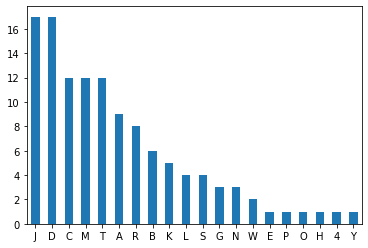

In [57]:
draft['first_letter'].value_counts().plot(kind='bar', rot=0);

In [58]:
get_team_max(draft, 'first_letter', keep=[team.owner for team in league.teams])

<ipython-input-55-9535c3ed8155>:96: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  value_counts['max_count'] = value_counts.max(axis=1)


first_letter,max_value,max_count
team_owner,,
Adam DiGiovanni,J,4.0
Austin Maaddi,B | C | D | M | T,2.0
Brian Clemens,C,4.0
Desi Pilla,K,3.0
Gianna M.,D,3.0
Justin DiGiovanni,J,4.0
Madi Weiss,D,4.0
N J,J,4.0


In [301]:
draft[(draft.first_letter == 'J') & (draft.team_owner == 'Gabriel S')]

,year,team_owner,team_id,player_name,player_id,round_num,round_pick,pro_team,proj_points,total_points,position,first_letter,points_surprise,positive_surprise,pick_num,value,perc_of_first
28,2018.0,Gabriel S,5.0,Jordan Howard,3060022.0,5.0,5.0,CHI,188.39,170.00,RB,J,-18.39,False,29.0,32.1,35.55%
40,2018.0,Gabriel S,5.0,Jarvis Landry,16790.0,7.0,5.0,CLE,164.54,176.62,WR,J,12.08,True,41.0,26.1,28.90%
112,2018.0,Gabriel S,5.0,Josh Doctson,2576019.0,19.0,5.0,WSH,142.56,87.20,WR,J,-55.36,False,113.0,8.6,9.52%
111,2019.0,Gabriel S,5.0,Jaylen Samuels,3116721.0,14.0,8.0,PIT,89.49,80.90,RB,J,-8.59,False,112.0,8.8,9.75%
9,2020.0,Gabriel S,5.0,Josh Jacobs,4047365.0,2.0,2.0,OAK,222.45,214.80,RB,J,-7.65,False,10.0,50.5,55.92%
73,2020.0,Gabriel S,5.0,J.K. Dobbins,4241985.0,10.0,2.0,BAL,121.09,159.50,RB,J,38.41,True,74.0,15.9,17.61%


WR      44
RB      35
QB      14
TE      10
D/ST     9
K        8
Name: position, dtype: int64

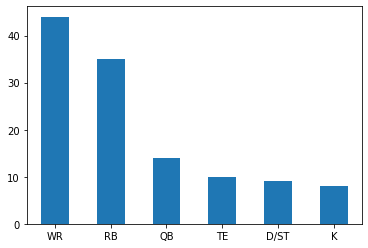

In [59]:
draft['position'].value_counts().plot(kind='bar', rot=0);
draft['position'].value_counts()

In [60]:
get_team_max(draft, 'position', keep=[team.owner for team in league.teams])

<ipython-input-55-9535c3ed8155>:96: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  value_counts['max_count'] = value_counts.max(axis=1)


position,max_value,max_count
team_owner,,
Adam DiGiovanni,WR,5
Austin Maaddi,WR,5
Brian Clemens,WR,6
Desi Pilla,WR,6
Gianna M.,RB | WR,5
Justin DiGiovanni,WR,5
Madi Weiss,RB | WR,5
N J,WR,7


LAR     23
KC      22
NO      21
NE      21
PHI     20
DAL     20
PIT     19
ATL     19
MIN     19
HOU     18
GB      18
SEA     18
SF      17
TB      17
BAL     17
DET     16
CLE     16
TEN     16
NYG     15
ARI     15
LAC     15
DEN     14
CAR     14
CHI     14
IND     13
JAX     12
CIN     12
BUF     12
OAK     10
WSH      9
NYJ      9
MIA      8
None     7
Name: pro_team, dtype: int64

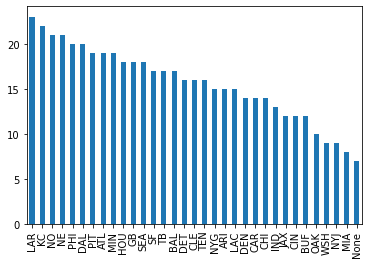

In [304]:
draft['pro_team'].value_counts().plot(kind='bar', rot=90);
draft['pro_team'].value_counts()

In [62]:
get_team_max(draft[draft.round_num <= 20], 'pro_team', keep=[team.owner for team in league.teams])

<ipython-input-55-9535c3ed8155>:96: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  value_counts['max_count'] = value_counts.max(axis=1)


pro_team,max_value,max_count
team_owner,,
Adam DiGiovanni,DAL | NYG,2.0
Austin Maaddi,BUF | SF,2.0
Brian Clemens,TB,5.0
Desi Pilla,PIT | SF,2.0
Gianna M.,LAR | PIT | SF,2.0
Justin DiGiovanni,BAL | JAX | KC,2.0
Madi Weiss,DEN | SEA,2.0
N J,CLE,3.0


In [306]:
get_team_max(draft.dropna(how='any'), 'player_name', keep=[team.owner for team in league.teams])

<ipython-input-276-45dd72f2a358>:92: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  value_counts['max_count'] = value_counts.max(axis=1)


player_name,max_value,max_count
team_owner,,
Desi Pilla,Antonio Brown,3.0
Gabriel S,Chris Godwin | David Montgomery | Mike Evans |...,2.0
Isabella Chirico,Dalvin Cook | Matt Ryan | Sterling Shepard | T...,2.0
Julia Selleck,Justin Tucker,3.0
Marc Chirico,Alshon Jeffery | Cooper Kupp | Davante Adams |...,2.0
Nikki Pilla,Amari Cooper | Christian Kirk | Courtland Sutt...,2.0
Vincent Chirico,Drew Brees,2.0


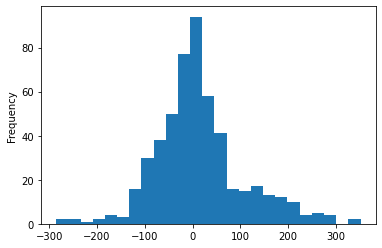

In [307]:
draft['points_surprise'].plot(kind='hist', rot=0, bins=25);

In [308]:
best_pick = draft[draft.year > 2017].sort_values(by='points_surprise', ascending=False).groupby('team_owner').first()
best_pick = best_pick[best_pick.index.isin([team.owner for team in league.teams])]
best_pick

,year,team_id,player_name,player_id,round_num,round_pick,pro_team,proj_points,total_points,position,first_letter,points_surprise,positive_surprise,pick_num,value,perc_of_first
team_owner,,,,,,,,,,,,,,,,
Desi Pilla,2019.0,1.0,Austin Ekeler,3068267.0,6.0,5.0,LAC,146.54,263.00,RB,A,116.46,True,45.0,24.5,27.13%
Gabriel S,2019.0,5.0,Christian McCaffrey,3117251.0,1.0,1.0,CAR,292.75,413.20,RB,C,120.45,True,1.0,90.3,100.00%
Isabella Chirico,2018.0,4.0,Christian McCaffrey,3117251.0,4.0,1.0,CAR,224.03,332.00,RB,C,107.97,True,19.0,39.4,43.63%
Julia Selleck,2018.0,2.0,Chris Carson,3919596.0,13.0,3.0,SEA,126.32,191.40,RB,C,65.08,True,75.0,15.7,17.39%
Marc Chirico,2020.0,3.0,Josh Allen,3918298.0,14.0,3.0,BUF,273.18,395.56,QB,J,122.38,True,107.0,9.6,10.63%
Nikki Pilla,2020.0,6.0,Ryan Tannehill,14876.0,18.0,7.0,TEN,239.16,343.86,QB,R,104.70,True,143.0,4.5,4.98%
Vincent Chirico,2020.0,7.0,Aaron Rodgers,8439.0,18.0,5.0,GB,264.22,382.76,QB,A,118.54,True,141.0,4.8,5.32%


In [309]:
best_pick = draft[draft.year > 2017].sort_values(by='points_surprise', ascending=False).groupby('position').first()
best_pick

,year,team_owner,team_id,player_name,player_id,round_num,round_pick,pro_team,proj_points,total_points,first_letter,points_surprise,positive_surprise,pick_num,value,perc_of_first
position,,,,,,,,,,,,,,,,
D/ST,2019.0,Desi Pilla,1.0,Ravens D/ST,-16033.0,15.0,4.0,BAL,95.85,164.00,R,68.15,True,116.0,8.2,9.08%
K,2019.0,Ellie Knecht,8.0,Harrison Butker,3055899.0,15.0,5.0,KC,138.47,162.00,H,23.53,True,117.0,8.0,8.86%
QB,2020.0,Marc Chirico,3.0,Josh Allen,3918298.0,14.0,3.0,BUF,273.18,395.56,J,122.38,True,107.0,9.6,10.63%
RB,2019.0,Gabriel S,5.0,Christian McCaffrey,3117251.0,1.0,1.0,CAR,292.75,413.20,C,120.45,True,1.0,90.3,100.00%
TE,2020.0,Isabella Chirico,4.0,Darren Waller,2576925.0,8.0,4.0,OAK,152.22,225.10,D,72.88,True,60.0,19.6,21.71%
WR,2020.0,Marc Chirico,3.0,Stefon Diggs,2976212.0,8.0,3.0,BUF,158.19,265.10,S,106.91,True,59.0,19.8,21.93%


In [310]:
worst_pick = draft[draft.year > 2017].sort_values(by='points_surprise', ascending=False).groupby('position').last()
worst_pick

,year,team_owner,team_id,player_name,player_id,round_num,round_pick,pro_team,proj_points,total_points,first_letter,points_surprise,positive_surprise,pick_num,value,perc_of_first
position,,,,,,,,,,,,,,,,
D/ST,2020.0,Vincent Chirico,7.0,49ers D/ST,-16025.0,10.0,5.0,SF,143.01,102.00,4,-41.01,False,77.0,15.2,16.83%
K,2019.0,Vincent Chirico,7.0,Stephen Gostkowski,9704.0,13.0,8.0,NE,135.67,32.00,S,-103.67,False,104.0,10.0,11.07%
QB,2019.0,Marc Chirico,3.0,Cam Newton,13994.0,12.0,2.0,CAR,302.42,16.68,C,-285.74,False,90.0,12.5,13.84%
RB,2018.0,Marc Chirico,3.0,Le'Veon Bell,15825.0,1.0,1.0,PIT,251.36,0.00,L,-251.36,False,1.0,90.3,100.00%
TE,2019.0,Isabella Chirico,4.0,David Njoku,3123076.0,13.0,2.0,CLE,121.00,12.60,D,-108.40,False,98.0,11.1,12.29%
WR,2019.0,Desi Pilla,1.0,Antonio Brown,13934.0,4.0,5.0,None,196.50,14.10,A,-182.40,False,29.0,32.1,35.55%


In [311]:
best_player = draft[draft.year == 2020].sort_values(by='total_points', ascending=False).groupby('position').first()
best_player

,year,team_owner,team_id,player_name,player_id,round_num,round_pick,pro_team,proj_points,total_points,first_letter,points_surprise,positive_surprise,pick_num,value,perc_of_first
position,,,,,,,,,,,,,,,,
D/ST,2020.0,Isabella Chirico,4.0,Steelers D/ST,-16023.0,9.0,5.0,PIT,144.70,155.00,S,10.30,True,69.0,17.1,18.94%
K,2020.0,Nikki Pilla,6.0,Greg Zuerlein,14993.0,16.0,7.0,DAL,123.77,146.00,G,22.23,True,127.0,6.6,7.31%
QB,2020.0,Marc Chirico,3.0,Josh Allen,3918298.0,14.0,3.0,BUF,273.18,395.56,J,122.38,True,107.0,9.6,10.63%
RB,2020.0,Marc Chirico,3.0,Alvin Kamara,3054850.0,2.0,3.0,NO,252.66,336.30,A,83.64,True,11.0,48.9,54.15%
TE,2020.0,Marc Chirico,3.0,Travis Kelce,15847.0,3.0,6.0,KC,219.35,260.26,T,40.91,True,22.0,36.9,40.86%
WR,2020.0,Nikki Pilla,6.0,Davante Adams,16800.0,3.0,2.0,GB,207.38,300.90,D,93.52,True,18.0,40.4,44.74%


In [312]:
worst_player = draft[draft.year == 2020].sort_values(by='total_points', ascending=False).groupby('position').last()
worst_player

,year,team_owner,team_id,player_name,player_id,round_num,round_pick,pro_team,proj_points,total_points,first_letter,points_surprise,positive_surprise,pick_num,value,perc_of_first
position,,,,,,,,,,,,,,,,
D/ST,2020.0,Julia Selleck,2.0,Chargers D/ST,-16024.0,18.0,6.0,LAC,117.03,88.00,C,-29.03,False,142.0,4.7,5.20%
K,2020.0,Desi Pilla,1.0,Chris Boswell,17372.0,17.0,8.0,PIT,125.87,99.00,C,-26.87,False,136.0,5.4,5.98%
QB,2020.0,Josh Barnhart,8.0,Dak Prescott,2577417.0,7.0,1.0,DAL,301.28,135.14,D,-166.14,False,49.0,23.1,25.58%
RB,2020.0,Marc Chirico,3.0,Marlon Mack,3139605.0,16.0,3.0,IND,123.08,7.10,M,-115.98,False,123.0,7.1,7.86%
TE,2020.0,Julia Selleck,2.0,Blake Jarwin,2991767.0,10.0,6.0,DAL,92.45,1.70,B,-90.75,False,78.0,15.0,16.61%
WR,2020.0,Nikki Pilla,6.0,Courtland Sutton,3128429.0,5.0,2.0,DEN,170.59,8.10,C,-162.49,False,34.0,29.4,32.56%


In [313]:
perc_boom = draft[draft.year > 2017].sort_values(by='positive_surprise', ascending=False).groupby('team_owner').mean()
perc_boom = perc_boom[['positive_surprise', 'proj_points', 'total_points', 'points_surprise']]
perc_boom.rename(columns={'positive_surprise':'Boom %',
                          'proj_points':'Avg. Projected Points',
                          'total_points':'Avg. Total Points',
                          'points_surprise': 'Avg. Points Surprise'},
                inplace=True)
perc_boom = perc_boom.sort_values(by='Boom %', ascending=False)

perc_boom = perc_boom[perc_boom.index.isin([team.owner for team in league.teams])]
perc_boom

,Boom %,Avg. Projected Points,Avg. Total Points,Avg. Points Surprise
team_owner,,,,
Desi Pilla,0.418182,174.974000,153.682909,-21.291091
Vincent Chirico,0.416667,178.891389,164.558333,-14.333056
Marc Chirico,0.400000,178.888182,158.467273,-20.420909
Nikki Pilla,0.388889,180.945278,160.252778,-20.692500
Gabriel S,0.381818,166.702000,165.204000,-1.498000
Julia Selleck,0.363636,179.057636,157.067636,-21.990000
Isabella Chirico,0.345455,180.287636,156.488727,-23.798909


<ipython-input-314-e28a3a153de9>:84: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


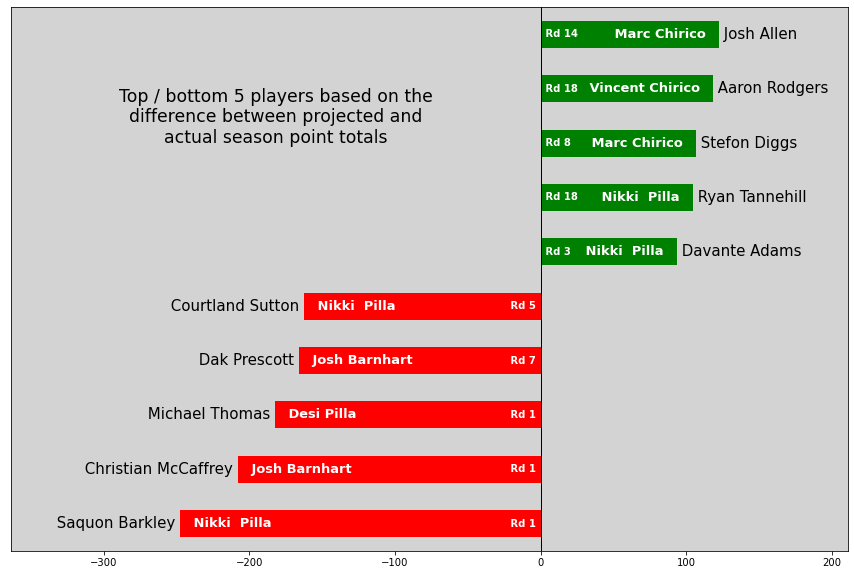

In [314]:
def plot_surprise(draft, year: int, owner: str, sort_by='round_num', asc=False):
    '''
    sort_by = {'round_num', 'points_surprise'}
    '''
    if sort_by == 'points_surprise': asc = True
    sub = draft[(draft.year == year) & (draft.team_owner == owner)].sort_values(by=sort_by, ascending=asc)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    sub.plot(x='player_name', 
             y='points_surprise', 
             kind='barh',
             color=(sub.points_surprise > 0).map({True: 'g', False: 'r'}),
             legend=None,
             ax=ax)
    plt.axvline(0, color='k', lw=1)
    ax.set_ylabel('')
    if sort_by == 'points_surprise': ax.set_yticks([])
    else: ax.set_yticklabels('Rd ' + sub.round_num.astype(str).str[:-2])

    for i, (name, height) in enumerate(zip(sub.player_name, sub.points_surprise)):
        ha = 'right' if height < 0 else 'left'
        ax.text(height, i, ' {} '.format(name),
                ha=ha, va='center', rotation=0, fontsize=10)

    xmin, xmax = ax.get_xlim()
    xmin -= len(sub.player_name.iloc[0])*3
    xmax += len(sub.player_name.iloc[-1])*2
    ax.set_xlim(xmin, xmax)
    ax.set_title(owner, fontsize='x-large')

    fig.show();
    
    
def plot_top_surprise(draft, year: int, top: int = 5):
    sub = draft[draft.year == year].sort_values(by='points_surprise', ascending=True).dropna(how='any')
    sub = pd.concat([sub.head(top), sub.tail(5)])
    
    fig, ax = plt.subplots(figsize=(15, 10))
    sub.plot(x='player_name', 
             y='points_surprise', 
             kind='barh',
             color=(sub.points_surprise > 0).map({True: 'g', False: 'r'}),
             legend=None,
             ax=ax)
    plt.axvline(0, color='k', lw=1)
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
#     ax.set_title('Points Surpise', size='xx-large')

    # Add player name
    for i, (name, height) in enumerate(zip(sub.player_name, sub.points_surprise)):
        ha = 'right' if height < 0 else 'left'
        text = ' {} '.format(name)
        ax.text(height, i, text, ha=ha, va='center', rotation=0, fontsize=15)

    # Add team owner
    for i, (owner, height) in enumerate(zip(sub.team_owner, sub.points_surprise)):
        ha = 'right' if height > 0 else 'left'
        text = '   {}   '.format(owner)
        ax.text(height, i, text, ha=ha, va='center', rotation=0, fontsize=13, weight='bold', color='white')
    
    # Add round number
    for i, (rd, height) in enumerate(zip(sub.round_num, sub.points_surprise)):
        ha = 'right' if height < 0 else 'left'
        text = ' Rd {:.0f} '.format(rd, owner)
        height = 1 if height > 0 else -1
        ax.text(height, i, text, ha=ha, va='center', rotation=0, fontsize=10, weight='bold', color='white')
        
    
    xmin, xmax = ax.get_xlim()
    xmin -= len(sub.player_name.iloc[0])*7
    xmax += len(sub.player_name.iloc[-1])*7
    ax.set_xlim(xmin, xmax)
    
    ax.text(xmin / 2, 
            int(top*1.5), 
            'Top / bottom 5 players based on the\ndifference between projected and\nactual season point totals',
            ha='center',
            fontsize='xx-large')    
    
    
    ax.set_facecolor('lightgray')
    fig.show();
    
# plot_surprise(draft, 2020, 'Desi Pilla', 'points_surprise')
# plot_surprise(draft, 2020, 'Josh Barnhart', 'round_num')
plot_top_surprise(draft, 2020)

<ipython-input-314-e28a3a153de9>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


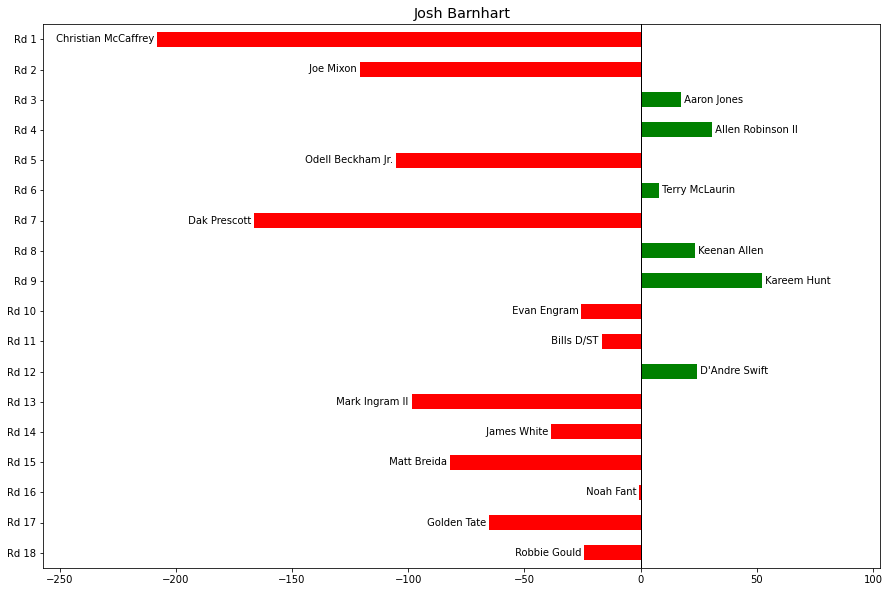

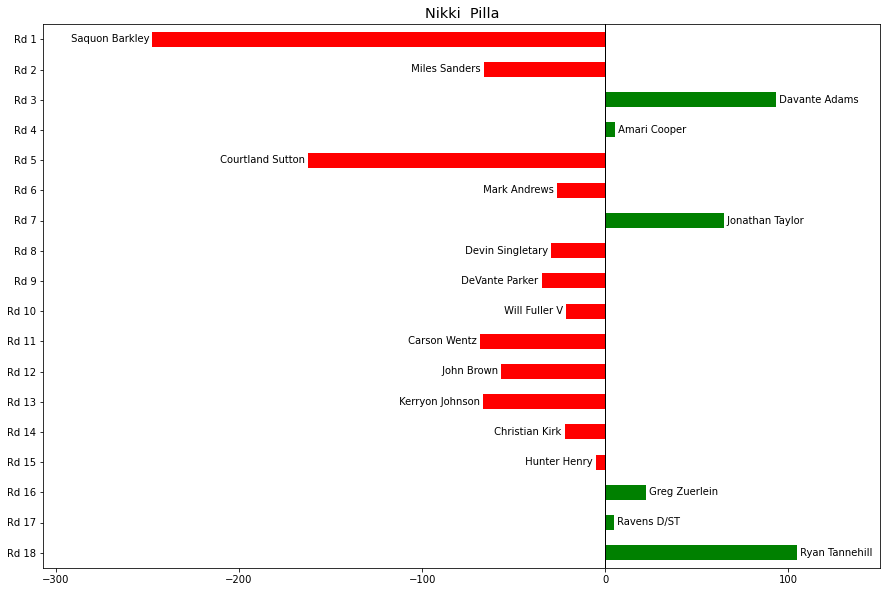

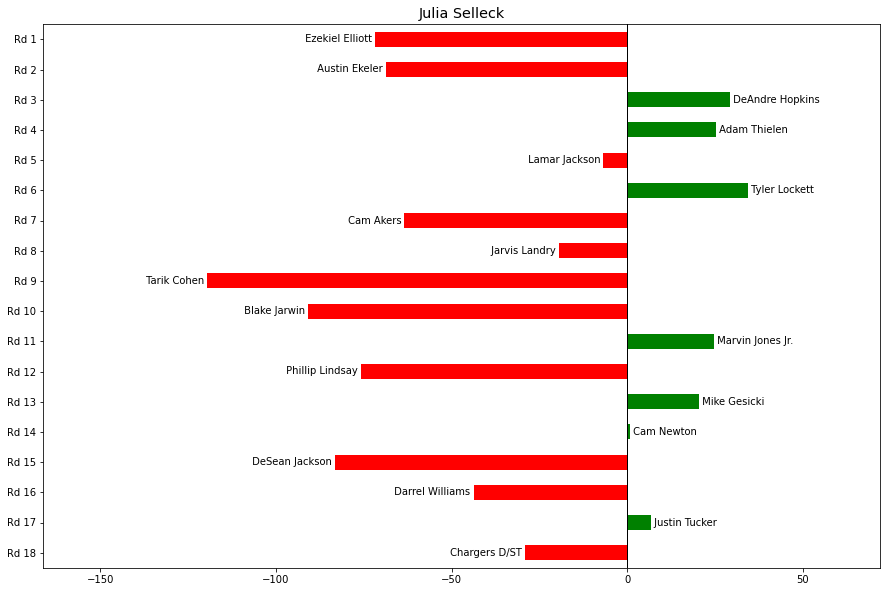

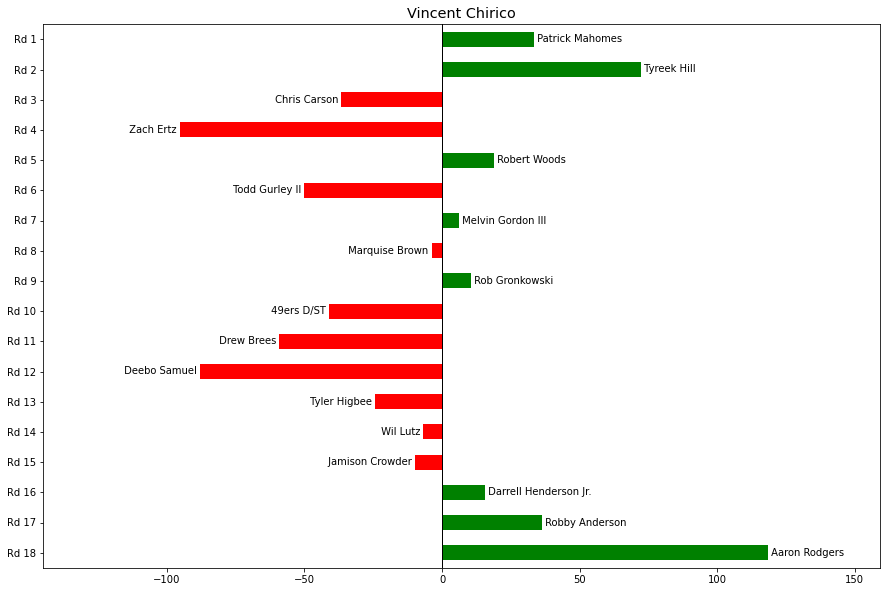

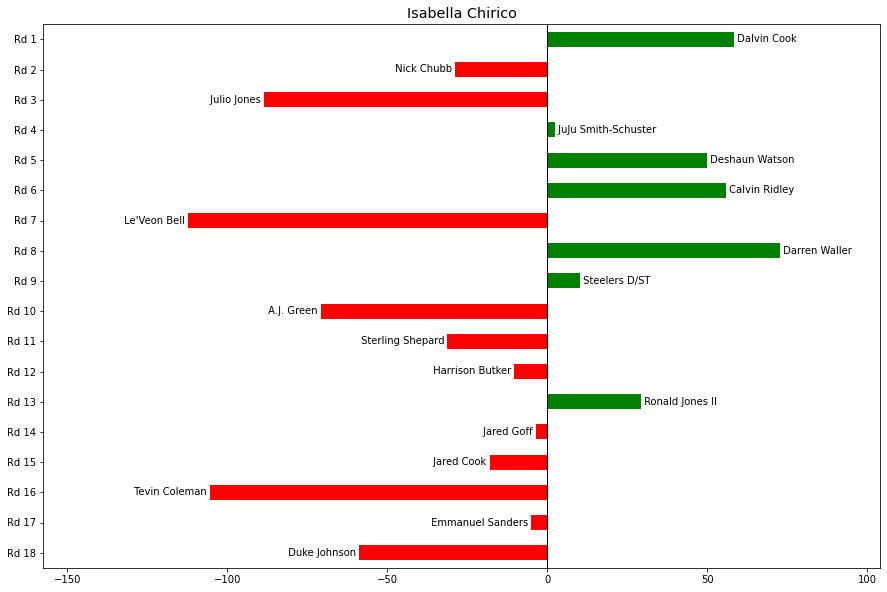

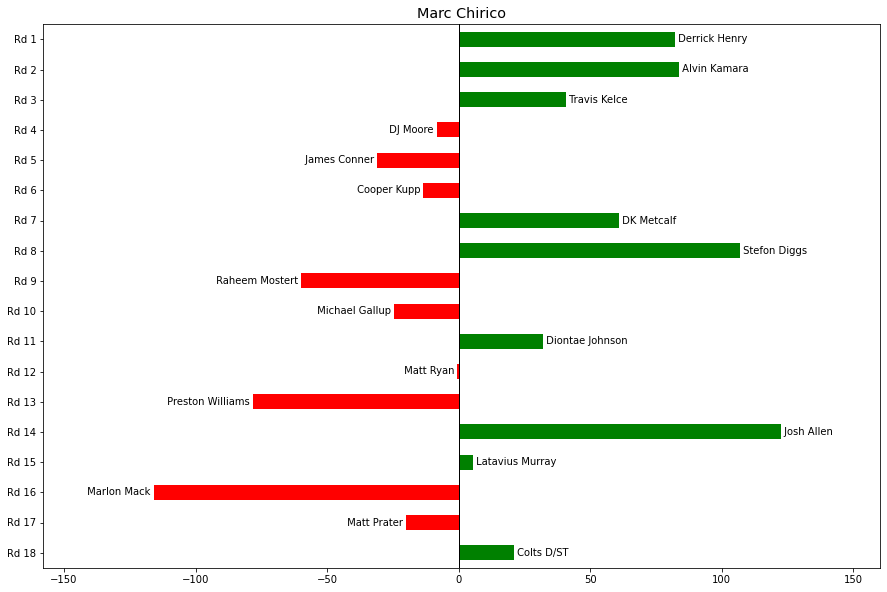

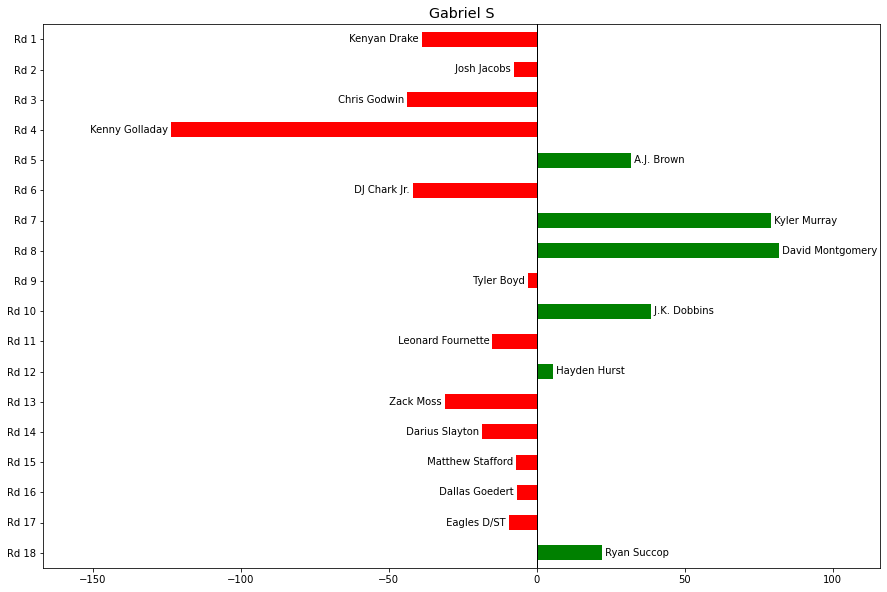

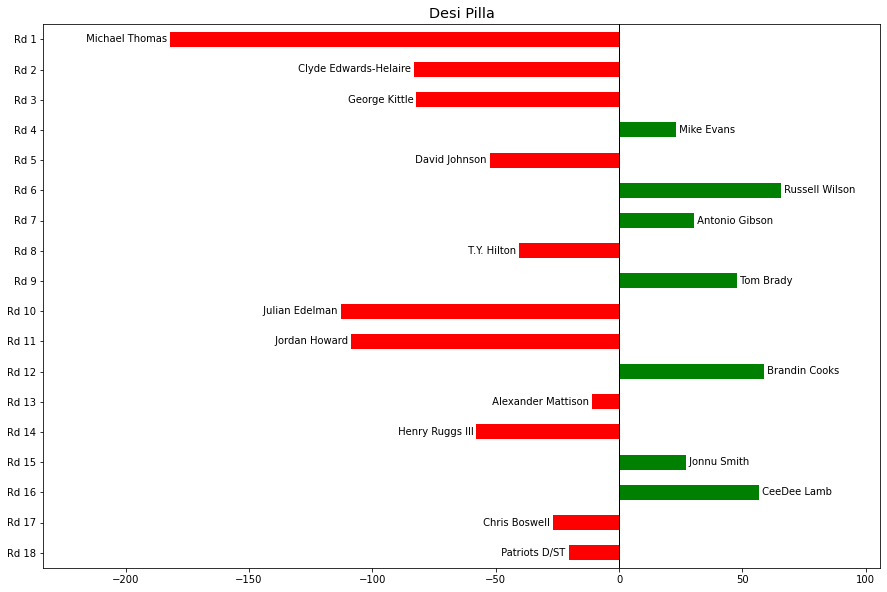

In [315]:
for name in draft[draft.year == 2020].team_owner.unique():
    plot_surprise(draft, 2020, name)

In [296]:
draft[draft.year > 2017].positive_surprise.mean()

0.39054726368159204

In [113]:
# league.load_roster_week(18)
